In [1]:
##Comandos para instalar librerías necesarias que no tenía
# !pip install statsbombpy
# !pip install mplsoccer
# !pip install highlight_text
# ! pip install pingouin

In [2]:
import pandas as pd
from pandas import json_normalize
import requests
import numpy as np
import time
from statsbombpy import sb #libreria con data de torneos de fútbol
from mplsoccer import VerticalPitch,Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import shapiro
import pingouin as pg



In [3]:
#Tabla de las competiciones abiertas de StatsBomb
competitions = sb.competitions()
competitions.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-06-12T07:44:38.559714,2021-06-13T16:17:31.694,None,2024-06-12T07:44:38.559714
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [4]:
#Vemos qué competiciones hay
competitions['competition_name'].unique()

array(['1. Bundesliga', 'African Cup of Nations', 'Champions League',
       'Copa America', 'Copa del Rey', "FA Women's Super League",
       'FIFA U20 World Cup', 'FIFA World Cup', 'Indian Super league',
       'La Liga', 'Liga Profesional', 'Ligue 1', 'Major League Soccer',
       'North American League', 'NWSL', 'Premier League', 'Serie A',
       'UEFA Euro', 'UEFA Europa League', "UEFA Women's Euro",
       "Women's World Cup"], dtype=object)

In [5]:
#Buscamos la Copa América para obtener su Id y consultar los aprtidos
competitions.loc[competitions['competition_name'].str.upper().str.contains('AMERICA')]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
21,223,282,South America,Copa America,male,False,True,2024,2024-07-15T18:00:33.653673,None,None,2024-07-15T18:00:33.653673
62,116,68,North and Central America,North American League,male,False,False,1977,2024-02-12T14:20:24.769832,2021-06-13T16:17:31.694,None,2024-02-12T14:20:24.769832


In [6]:
#Buscamos la EuroCOpa para obtener su Id y consultar los aprtidos
competitions.loc[competitions['competition_name'].str.upper().str.contains('EUR')]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
68,55,282,Europe,UEFA Euro,male,False,True,2024,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,2024-07-15T15:52:24.778809,2024-07-15T15:48:50.315500
69,55,43,Europe,UEFA Euro,male,False,True,2020,2024-04-16T12:44:40.558402,2024-04-16T12:47:18.505110,2024-04-16T12:47:18.505110,2024-04-16T12:44:40.558402
70,35,75,Europe,UEFA Europa League,male,False,False,1988/1989,2024-02-12T14:45:05.702250,2021-06-13T16:17:31.694,None,2024-02-12T14:45:05.702250
71,53,106,Europe,UEFA Women's Euro,female,False,True,2022,2024-02-13T13:27:17.178263,2024-02-13T13:30:52.820588,2024-02-13T13:30:52.820588,2024-02-13T13:27:17.178263


In [7]:
#Creamos diccionario con las competiciones que queremos llevar a Dataframe
#Y sus respectivas temporadas
#Copa América 223 y 282
#Euro Copa 55 y 282
my_dict = {'competition' : [223,55], 'season' : [282,282]}

In [8]:
#Función que nos permite obtener un dataframe con todas las competiciones que definamos
#Se necesita un diccionario con las id de la comeptición y su temporada respectiva
def obtener_matches(my_dict):
    """Permite obtener las competiciones que se necesitan.
    Deben ingresarse como un diccionario que contenga en la primera Key
    el Id de la competición, y en la segunda Key el Id de la temporada
    respectiva"""   
    matches = pd.DataFrame([])
    for comp, seas in zip(my_dict['competition'], my_dict['season']):
        each_match = sb.matches(competition_id=comp, season_id=seas)
        matches = pd.concat([matches,each_match], axis = 0)
    return matches

In [9]:
#ejectuamos la función anterior y el resultado lo asignamos a matches
matches = obtener_matches(my_dict)

In [10]:
#Creamos algunos campos adicionales a matches que pudiesen sernos útiles
matches['marcador'] = matches['home_score'].astype('str')+'-'+matches['away_score'].astype('str')
matches['match'] = matches['home_team']+'-'+matches['away_team']
matches['total_goals'] = matches['home_score']+matches['away_score']
matches['winner'] = matches.apply(lambda x:x['home_team'] if x['home_score']>x['away_score'] 
                     else x['away_team'] if x['home_score']<x['away_score']
                       else 'Empate', axis = 1)

In [11]:
#con esto buscamos ver toas las columnas al ver matches, ya que por defecto
#se acotan en la vista si son muchas
pd.set_option("display.max.columns", None)

In [12]:
#verificamos cantidad de partidos
matches.shape[0]

83

In [13]:
matches.head(3)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version,marcador,match,total_goals,winner
0,3943077,2024-07-15,04:15:00.000,South America - Copa America,2024,Argentina,Colombia,1,0,available,unscheduled,2024-07-15T15:50:08.671355,None,6,Final,Hard Rock Stadium,Raphael Claus,Lionel Sebastián Scaloni,Néstor Gabriel Lorenzo,1.1.0,2,2,1-0,Argentina-Colombia,1,Argentina
1,3943076,2024-07-14,03:00:00.000,South America - Copa America,2024,Canada,Uruguay,2,2,available,unscheduled,2024-07-15T07:57:02.660641,None,6,3rd Place Final,Bank of America Stadium,Alexis Herrera,Jesse Marsch,Marcelo Alberto Bielsa Caldera,1.1.0,2,2,2-2,Canada-Uruguay,4,Empate
2,3942852,2024-07-11,03:00:00.000,South America - Copa America,2024,Uruguay,Colombia,0,1,available,unscheduled,2024-07-15T18:00:33.653673,None,5,Semi-finals,Bank of America Stadium,César Arturo Ramos Palazuelos,Marcelo Alberto Bielsa Caldera,Néstor Gabriel Lorenzo,1.1.0,2,2,0-1,Uruguay-Colombia,1,Colombia


In [14]:
#obtenemos la tabla de una forma más amigable para análisis posteriores
#en la práctica, esta tabla la hice cuando ya había avanzado en el código,
#y me di cuenta que necesitaba este formato (fue resultado de iterar algunas ideas)
matches_equipos = pd.DataFrame([])
for row in range(0,len(matches)):
    matches_aux = pd.DataFrame([])
    team = [matches.iloc[row, 5],matches.iloc[row, 6]] 
    goals_for = [matches.iloc[row, 7],matches.iloc[row, 8]] 
    goals_against = [matches.iloc[row, 8],matches.iloc[row, 7]] 
    competition = matches.iloc[row, 3]

    matches_aux['team'] = team
    matches_aux['goals_for'] = goals_for
    matches_aux['goals_against'] = goals_against
    matches_aux['goals_difference'] = matches_aux['goals_for']-matches_aux['goals_against']
    matches_aux['winner'] = matches_aux['team'].apply(lambda x: 1 if x == matches.iloc[row,25] else 0)
    matches_aux['week'] = matches.iloc[row, 13]
    matches_aux['competition'] = competition
    matches_aux['match_id'] = matches.iloc[row, 0]
    matches_equipos = pd.concat([matches_equipos,matches_aux], axis = 0)
    

In [15]:
matches_equipos

,team,goals_for,goals_against,goals_difference,winner,week,competition,match_id
0,Argentina,1,0,1,1,6,South America - Copa America,3943077
1,Colombia,0,1,-1,0,6,South America - Copa America,3943077
0,Canada,2,2,0,0,6,South America - Copa America,3943076
1,Uruguay,2,2,0,0,6,South America - Copa America,3943076
0,Uruguay,0,1,-1,0,5,South America - Copa America,3942852
...,...,...,...,...,...,...,...,...
1,Croatia,0,3,-3,0,1,Europe - UEFA Euro,3930160
0,Hungary,1,3,-2,0,1,Europe - UEFA Euro,3930159
1,Switzerland,3,1,2,1,1,Europe - UEFA Euro,3930159
0,Germany,5,1,4,1,1,Europe - UEFA Euro,3930158


In [16]:
#Verificamos que en nuestro nuevo dataframe se mantenga la misma cantidad de matches
len(matches_equipos['match_id'].unique())

83

In [17]:
#llevamos a una lista los partidos para luego obtener las estadísticas para cada uno
matches_list = matches['match_id'].to_list()
print(f"{len(matches_list)} partidos a consultar")

83 partidos a consultar


In [18]:
#Vemos cuántos partidos son por competición
matches.groupby('competition')['match_id'].count().reset_index()

,competition,match_id
0,Europe - UEFA Euro,51
1,South America - Copa America,32


In [19]:
#vemos cuántos equipos son por competición
matches.groupby('competition')['home_team'].nunique().reset_index()

,competition,home_team
0,Europe - UEFA Euro,24
1,South America - Copa America,16


In [20]:
#vemos cuántos equipos son por competición (validando nuestro dataframe creado)
matches_equipos.groupby('competition')['team'].nunique().reset_index()

,competition,team
0,Europe - UEFA Euro,24
1,South America - Copa America,16


In [21]:
#Acá vemos los tipos de eventos disponibles
#elegiremos los que según nuestro criterio deban medir el desempeño de los equipos
sb.events(match_id=3943077, split=True, flatten_attrs=False).keys()

dict_keys(['starting_xis', 'half_starts', 'passes', 'ball_receipts', 'carrys', 'pressures', 'shots', 'goal_keepers', 'clearances', 'blocks', 'dribbled_pasts', 'dribbles', 'duels', 'ball_recoverys', 'miscontrols', 'interceptions', 'foul_committeds', 'foul_wons', 'dispossesseds', 'tactical_shifts', 'injury_stoppages', 'offsides', 'player_offs', 'player_ons', 'shields', 'half_ends', '50/50s', 'referee_ball_drops', 'substitutions', 'bad_behaviours'])

In [22]:
#guardamos en una lista los tipos de eventos
#Los usaremos para crear dataframes por cada eventos
#Considerar que los eventos están en un dataframe diferente a "matches"
#Los eventos se pueden consultar en un gran dataframe consolidado
#o se pueden consultar por separado. Prefiero esto último porque lo considero más "limpio"
event_types = ['passes','miscontrols','dribbles','dribbled_pasts','ball_recoverys',
               'dispossesseds','interceptions','shots','pressures']

In [23]:
def process_event_types(event_types, match_ids):
    #creamos un dicionario vació donde apendearemos cada evento por cada match
    dataframes = {}
    start_time = time.time()   
    # Iteramos por cada evento guardado previamente en nuestra lista event_types
    for event in event_types:
        print(f"Procesando evento: {event}")
        # Iteramos por cada match_id guardado en la lista que ingresamos
        for match_id in match_ids:
            df = sb.events(match_id=match_id, split=True, flatten_attrs=False)[event]
            #teníamos eventos con símbolo "/" en el nombre por lo que lo "Limpiamos"
            event_clean = event.replace('/', '_')
            #Creamos una llave sin valores en el diccionario dataframes que se llame df_nombre_del_evento
            #Luego  a esta llave le apendeamos la da del evento obtenido como su valor
            if f'df_{event_clean}' not in dataframes:
                dataframes[f'df_{event_clean}'] = []
            dataframes[f'df_{event_clean}'].append(df)
        print(f"Se han procesado {len(match_ids)} partidos")

    # # Concatenar los DataFrames de todos los match_ids para cada evento
    for key in dataframes.keys():
        # Verificación de que todos los elementos en dataframes[key] son DataFrames
        # Esto se hace por que nos daba un error en un evento y quería identificar en cuál :(
        #Finalmente asignamos el texto de la key del diccionario al nombre del dataframe
        if all(isinstance(df, pd.DataFrame) for df in dataframes[key]):
            globals()[key] = pd.concat(dataframes[key], ignore_index=True)
        else:
            print(f"Error: dataframes[{key}] contiene elementos que no son DataFrames")
            return dataframes[key]

    # Verificación de la creación de variables
    for key in dataframes.keys():
        if key in globals():
            print(f"La variable {key} se ha creado correctamente.")
        else:
            print(f"Error al crear la variable {key}.")

    end_time = time.time()  # Capturar el tiempo de finalización
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido

    print(f"Tiempo total de procesamiento: {elapsed_time:.2f} segundos")

In [24]:
process_event_types(event_types, matches_list)

Procesando evento: passes
Se han procesado 83 partidos
Procesando evento: miscontrols
Se han procesado 83 partidos
Procesando evento: dribbles
Se han procesado 83 partidos
Procesando evento: dribbled_pasts
Se han procesado 83 partidos
Procesando evento: ball_recoverys
Se han procesado 83 partidos
Procesando evento: dispossesseds
Se han procesado 83 partidos
Procesando evento: interceptions
Se han procesado 83 partidos
Procesando evento: shots
Se han procesado 83 partidos
Procesando evento: pressures
Se han procesado 83 partidos
La variable df_passes se ha creado correctamente.
La variable df_miscontrols se ha creado correctamente.
La variable df_dribbles se ha creado correctamente.
La variable df_dribbled_pasts se ha creado correctamente.
La variable df_ball_recoverys se ha creado correctamente.
La variable df_dispossesseds se ha creado correctamente.
La variable df_interceptions se ha creado correctamente.
La variable df_shots se ha creado correctamente.
La variable df_pressures se ha

In [25]:
def boxplot_comparation(df, hue, y1,y2,y3):
    # Crear una paleta de colores personalizada
    palette = sns.color_palette("Dark2", len(df[hue].unique())) #husl
    fig = plt.figure(figsize=(18, 9))

    # Boxplot para las variables que indiquemos
    plt.subplot(2, 3, 1)
    sns.boxplot(x=hue, y= y1, data=df, hue = 'competition', palette=palette)
    plt.title(f'{y1} por {hue}')
    plt.xlabel(hue)
    plt.ylabel(f'{y1}')

    plt.subplot(2, 3, 2)
    sns.boxplot(x=hue, y=y2, data=df, hue = 'competition', palette=palette)
    plt.title(f'{y2} por {hue}')
    plt.xlabel(hue)
    plt.ylabel(f'{y2}')

    plt.subplot(2, 3, 3)
    sns.boxplot(x=hue, y=y3, hue = 'competition', data=df, palette=palette)
    plt.title(f'{y3} por {hue}')
    plt.xlabel(hue)
    plt.ylabel(f'{y3}')

    # Expresamos las mismas variables, pero en histplot
    plt.subplot(2, 3, 4)
    sns.histplot(data=df,  x=y1, hue="competition",  kde=True, palette=palette)

    plt.subplot(2, 3, 5)
    sns.histplot(data=df,  x=y2, hue="competition",  kde=True, palette=palette)

    plt.subplot(2, 3, 6)
    sns.histplot(data=df,  x=y3, hue="competition",  kde=True, palette=palette)


    plt.tight_layout()
    return plt.show()

# Passes

In [26]:
def treatment_passes(df_passes):
  columns =['length','end_location','recipient.name','height.name','body_part.name',
  'type.name','outcome.name','shot_assist','goal_assist','deflected']
  df_passesinfo = pd.json_normalize(df_passes['pass'])[columns]
  df_passes = df_passes.join(df_passesinfo)
  df_passes.drop(columns = ['pass','team','team_id'], inplace = True)
  df_passes.loc[(df_passes['outcome.name'].isnull()), 'pass_successful'] = 1
  df_passes.loc[~(df_passes['outcome.name'].isnull()), 'pass_successful'] = 0
  columns_final = ['id','minute','second', 'type', 'possession_team','player',
  'play_pattern','position','match_id','possession_team_id']
  df_passes.rename(columns = {'possession_team':'team', 'possession_team_id':'team_id'}, inplace = True)
  columns_final = ['id','match_id','minute','second','team','team_id','player','position','location',
                   'end_location','recipient.name',	'height.name','body_part.name',
                   'pass_successful']
  df_passes = df_passes[columns_final]
  return df_passes


In [27]:
df_passes = treatment_passes(df_passes)

In [28]:
df_passes.head()

,id,match_id,minute,second,team,team_id,player,position,location,end_location,recipient.name,height.name,body_part.name,pass_successful
0,cb778361-dd33-474a-bb6d-f958ad4189a1,3943077,0,0,Argentina,779,Lionel Andrés Messi Cuccittini,Right Center Forward,"[61.0, 40.1]","[51.0, 40.0]",Enzo Fernandez,Ground Pass,Right Foot,1.0
1,3cc63531-4039-468b-9b5b-6e1a5a0cea25,3943077,0,2,Argentina,779,Enzo Fernandez,Left Defensive Midfield,"[48.6, 41.0]","[45.6, 54.5]",Rodrigo Javier De Paul,Ground Pass,Right Foot,1.0
2,51fd0d6a-4db7-4cd1-8d18-6d9757990950,3943077,0,3,Argentina,779,Rodrigo Javier De Paul,Right Defensive Midfield,"[45.6, 54.5]","[31.1, 55.4]",Cristian Gabriel Romero,Ground Pass,Right Foot,1.0
3,6a25806b-21d8-4af6-9dda-16eb8a794c96,3943077,0,10,Argentina,779,Cristian Gabriel Romero,Right Center Back,"[32.6, 52.8]","[50.7, 6.2]",Nicolás Alejandro Tagliafico,High Pass,Right Foot,1.0
4,37b14799-729b-47cb-9326-3d070da61814,3943077,0,14,Argentina,779,Nicolás Alejandro Tagliafico,Left Back,"[49.7, 6.4]","[27.0, 21.6]",Lisandro Martínez,Ground Pass,Left Foot,1.0


In [29]:
passes_by_match = df_passes.groupby(['team','match_id']).agg(passes_count = ('id', 'count'),
                                                     successful_passes = ('pass_successful', 'sum')).reset_index()

df_compared_passes = passes_by_match.merge(matches_equipos, on = ['match_id','team'], how = 'left'
                                    ).assign(successful_pass_ratio=lambda x: x['successful_passes'] / x['passes_count'])

In [30]:
passes_by_match.head(3)

,team,match_id,passes_count,successful_passes
0,Albania,3930161,399,338.0
1,Albania,3930167,327,256.0
2,Albania,3930179,438,354.0


In [31]:
df_compared_passes.head(3)

,team,match_id,passes_count,successful_passes,goals_for,goals_against,goals_difference,winner,week,competition,successful_pass_ratio
0,Albania,3930161,399,338.0,1,2,-1,0,1,Europe - UEFA Euro,0.847118
1,Albania,3930167,327,256.0,2,2,0,0,2,Europe - UEFA Euro,0.782875
2,Albania,3930179,438,354.0,0,1,-1,0,3,Europe - UEFA Euro,0.808219


<Axes: xlabel='week', ylabel='successful_pass_ratio'>

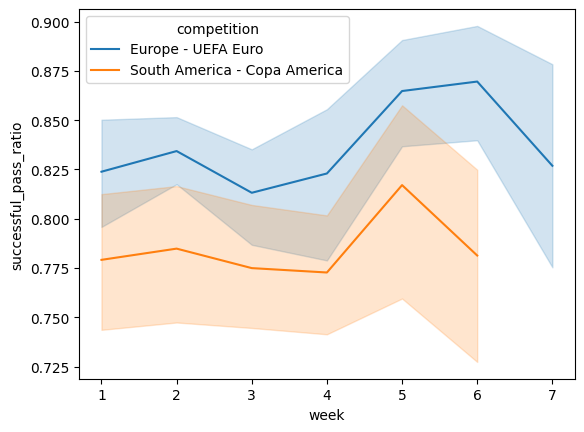

In [32]:
#Acá estoy jugando un pcoo con otras gráficas
#por ahora, los insights que puedan salir de acá los dejo en pausa
# para enfocarme en el problema inicial
sns.lineplot(data=df_compared_passes, x='week',y='successful_pass_ratio', hue='competition')

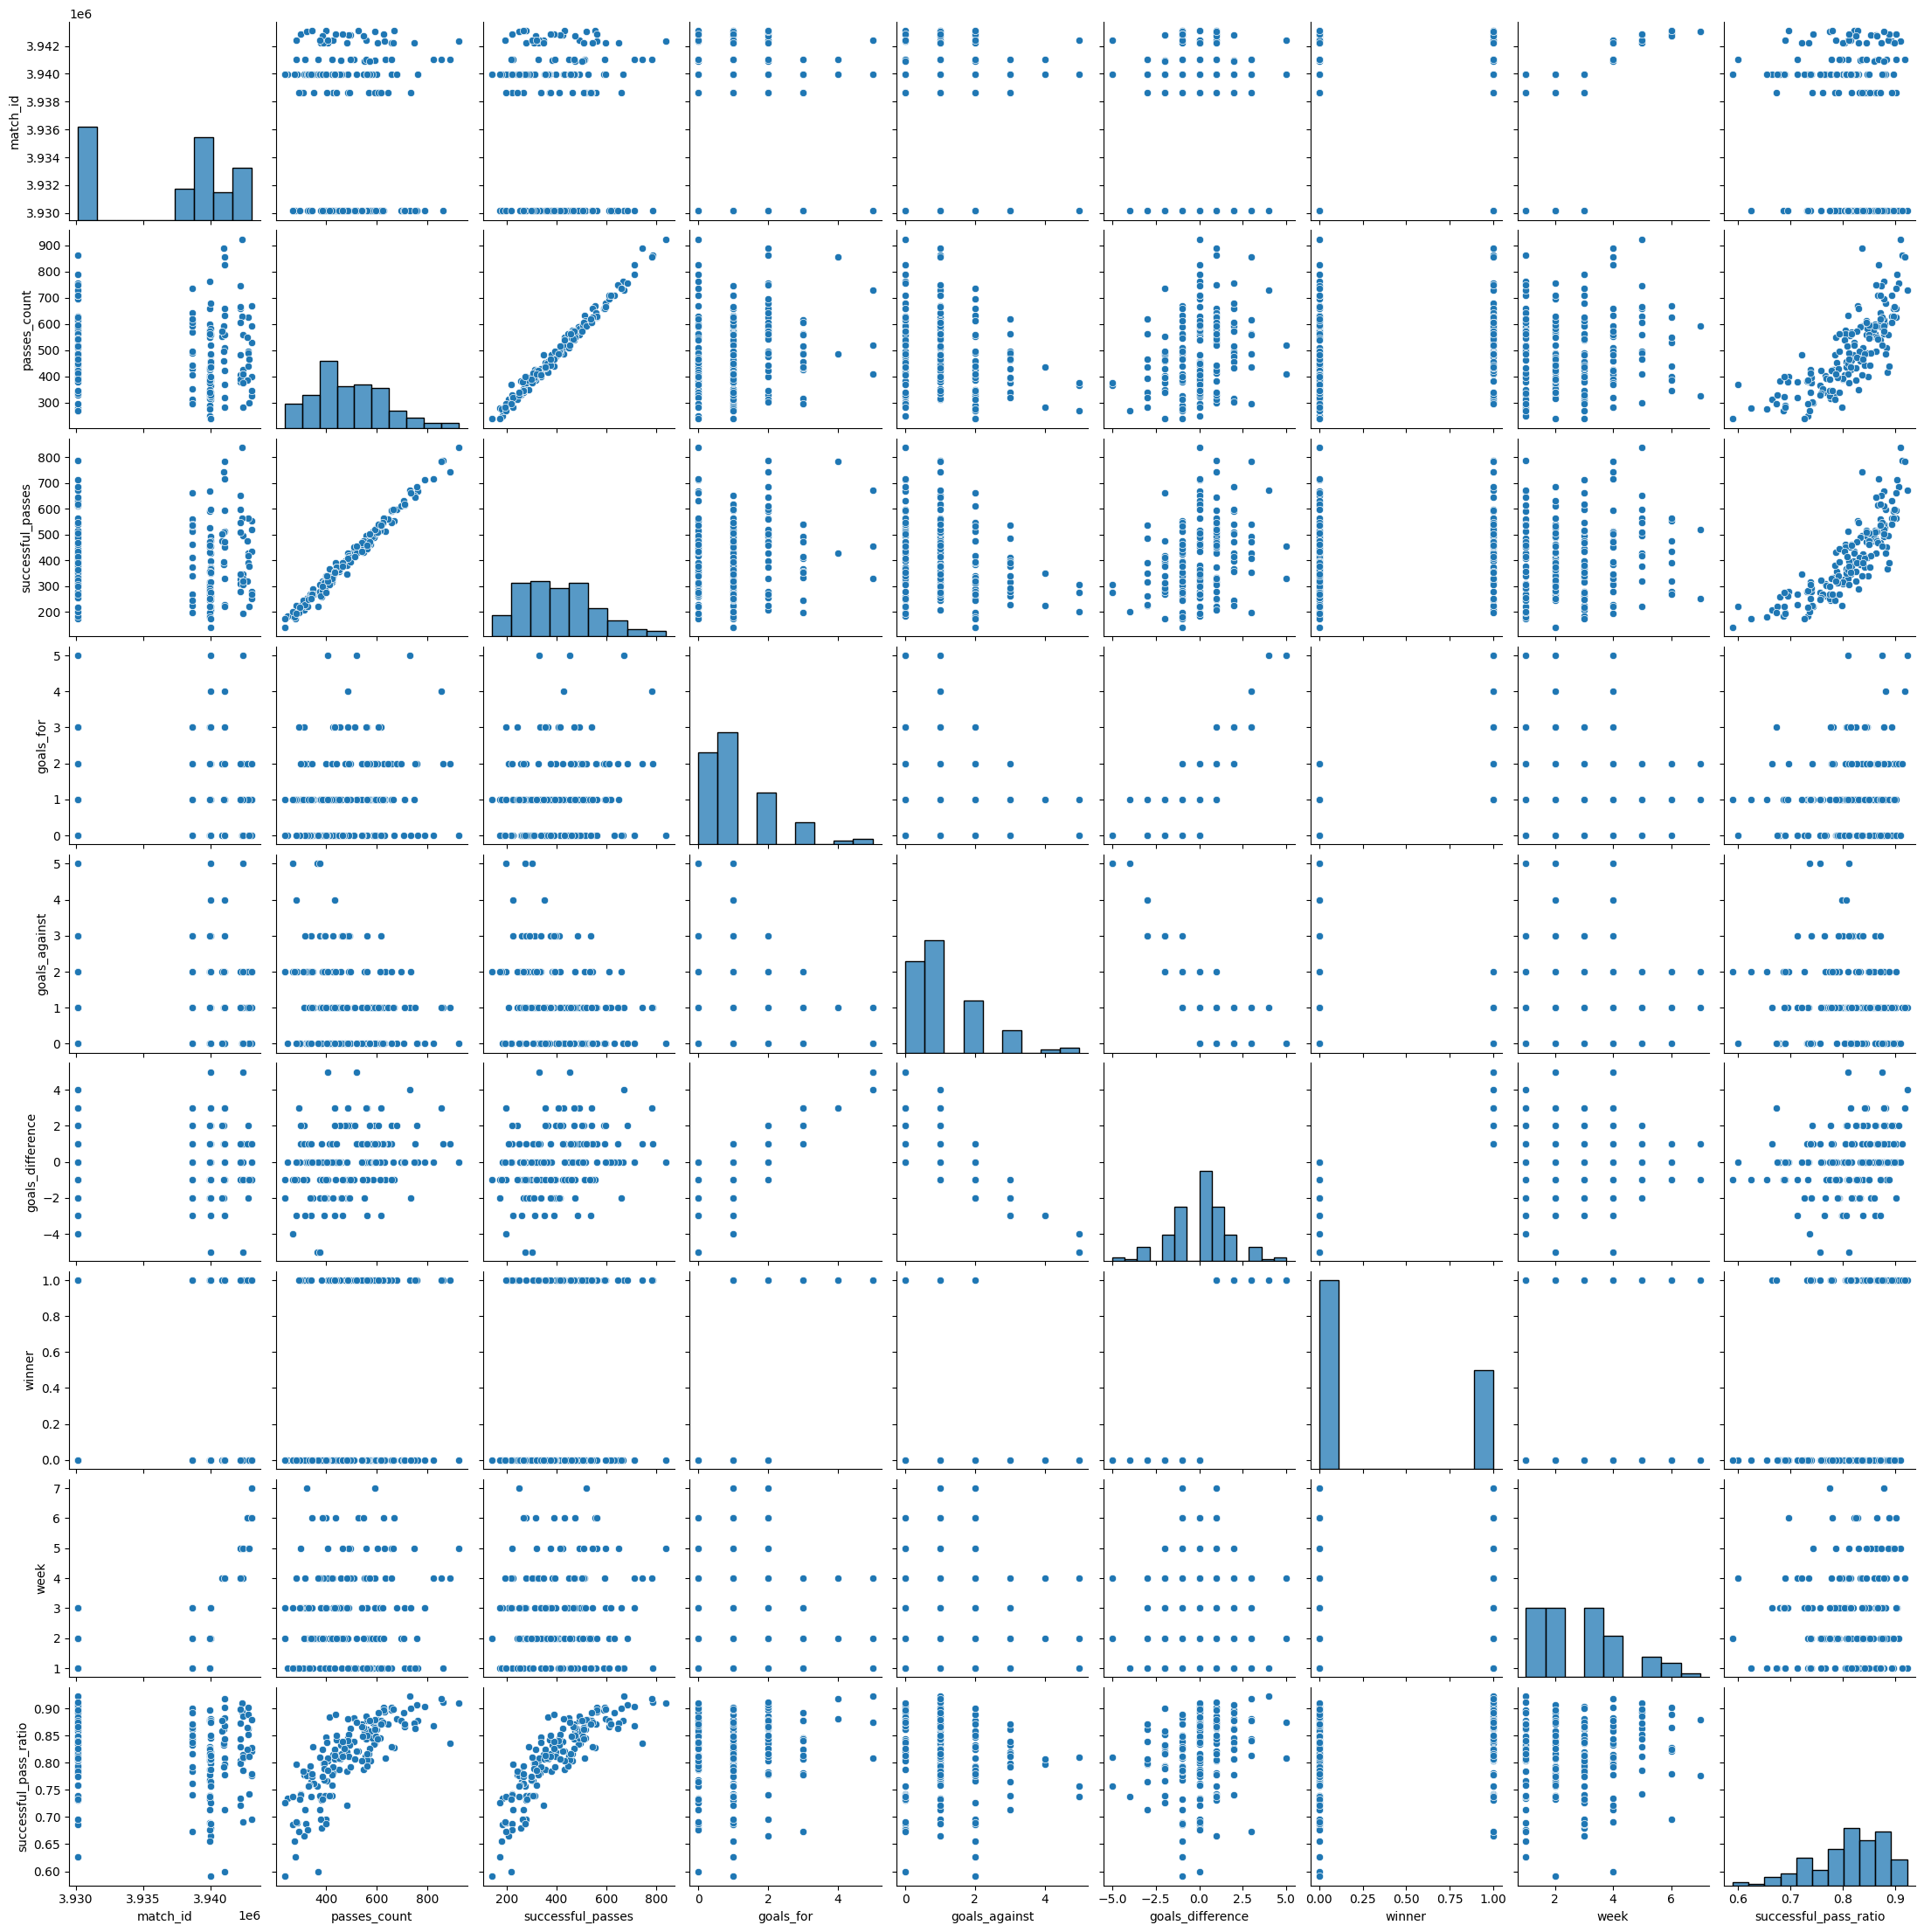

In [33]:
sns.pairplot(data = df_compared_passes)

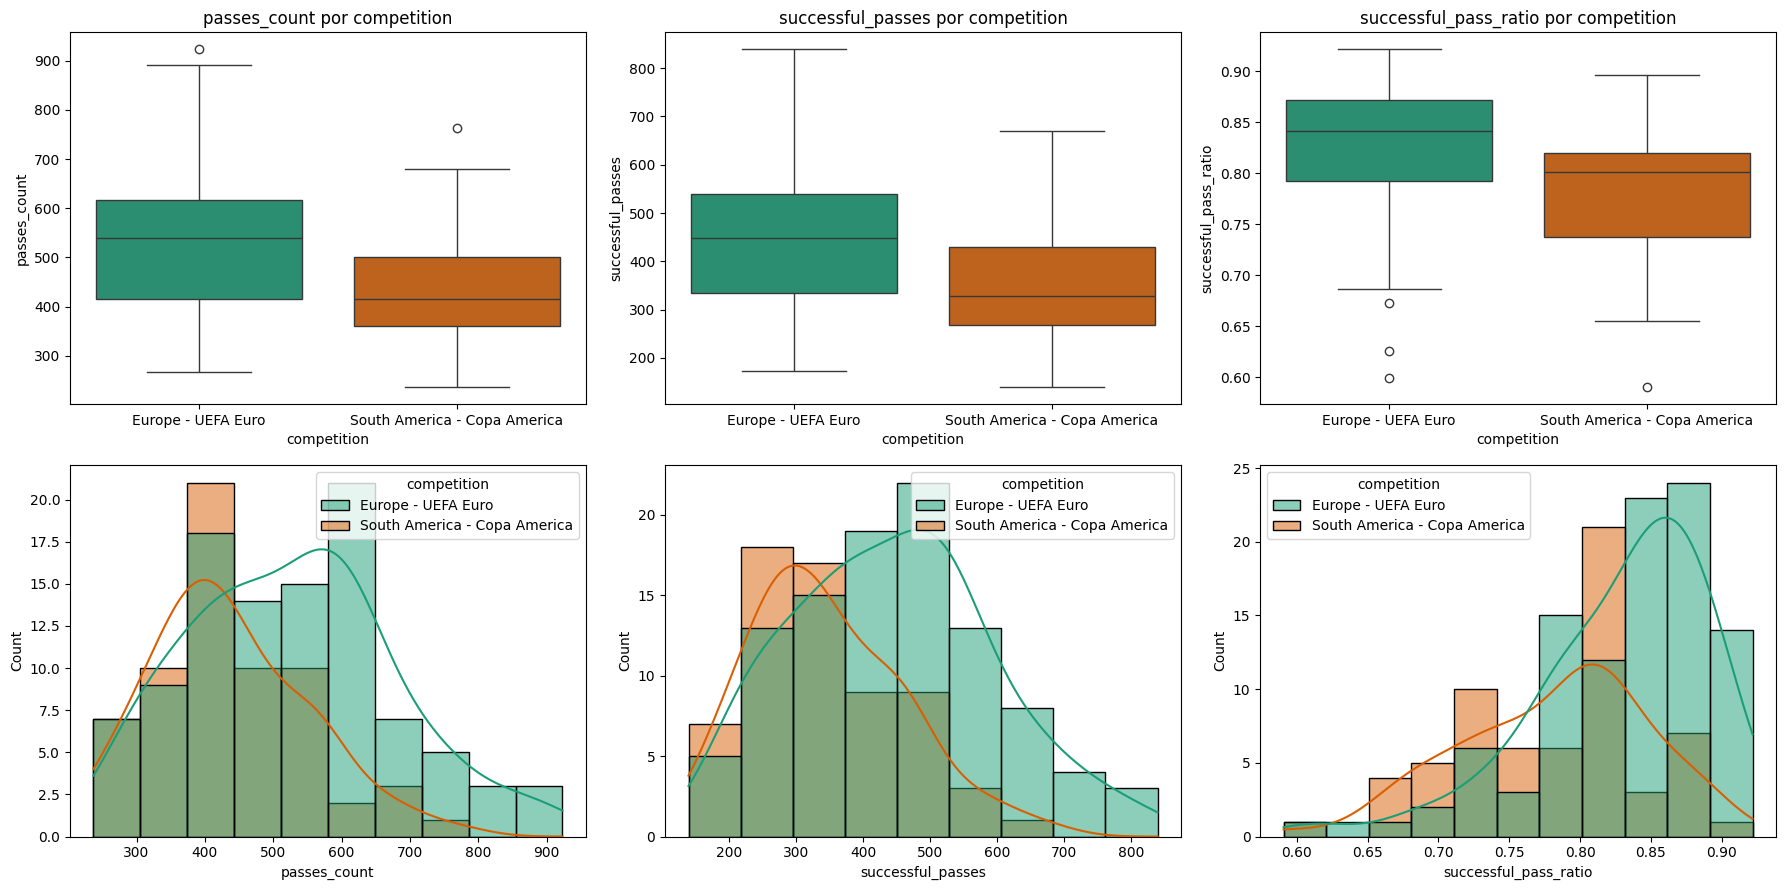

In [34]:
passes_charts =boxplot_comparation(df_compared_passes, 'competition', 'passes_count','successful_passes','successful_pass_ratio')
passes_charts

# Miscontrols

In [35]:
def treatment_miscontrols(df_miscontrols):
  columns_final =['id','minute','second','type','team','player',
  'play_pattern','position','match_id','team_id','under_pressure']
  df_miscontrols['under_pressure'] = df_miscontrols['under_pressure'].fillna(0).astype(int)
  df_miscontrols = df_miscontrols[columns_final]
  df_miscontrols['no_pressure'] = df_miscontrols['under_pressure'].replace({0:1,1:0})
  return df_miscontrols

In [36]:
df_miscontrols = treatment_miscontrols(df_miscontrols)

C:\Users\56981\AppData\Local\Temp\ipykernel_31652\3285727749.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miscontrols['no_pressure'] = df_miscontrols['under_pressure'].replace({0:1,1:0})


In [37]:
df_miscontrols.head(3)

,id,minute,second,type,team,player,play_pattern,position,match_id,team_id,under_pressure,no_pressure
0,02699bcc-06fa-4e49-8a2b-dce224be977c,3,33,Miscontrol,Colombia,Luis Fernando Díaz Marulanda,From Goal Kick,Left Center Forward,3943077,769,0,1
1,fac5eca3-a8d0-4b0c-9d95-3fff0876fb22,4,18,Miscontrol,Colombia,James David Rodríguez Rubio,Regular Play,Center Attacking Midfield,3943077,769,1,0
2,f3e02874-61e8-4c43-be7f-9b39b3ac46ed,13,51,Miscontrol,Argentina,Rodrigo Javier De Paul,Regular Play,Right Defensive Midfield,3943077,779,1,0


In [38]:
miscontrols_by_match = df_miscontrols.groupby(['team','match_id']).agg(miscontrols_count = ('id', 'count'),
                                                     miscontrols_no_pressure = ('no_pressure', 'sum')).reset_index()
df_compared_miscontrols = miscontrols_by_match.merge(matches_equipos, on = ['match_id','team'], how = 'left'
                                    ).assign(miscontrol_np_ratio=lambda x: x['miscontrols_no_pressure'] / x['miscontrols_count'])

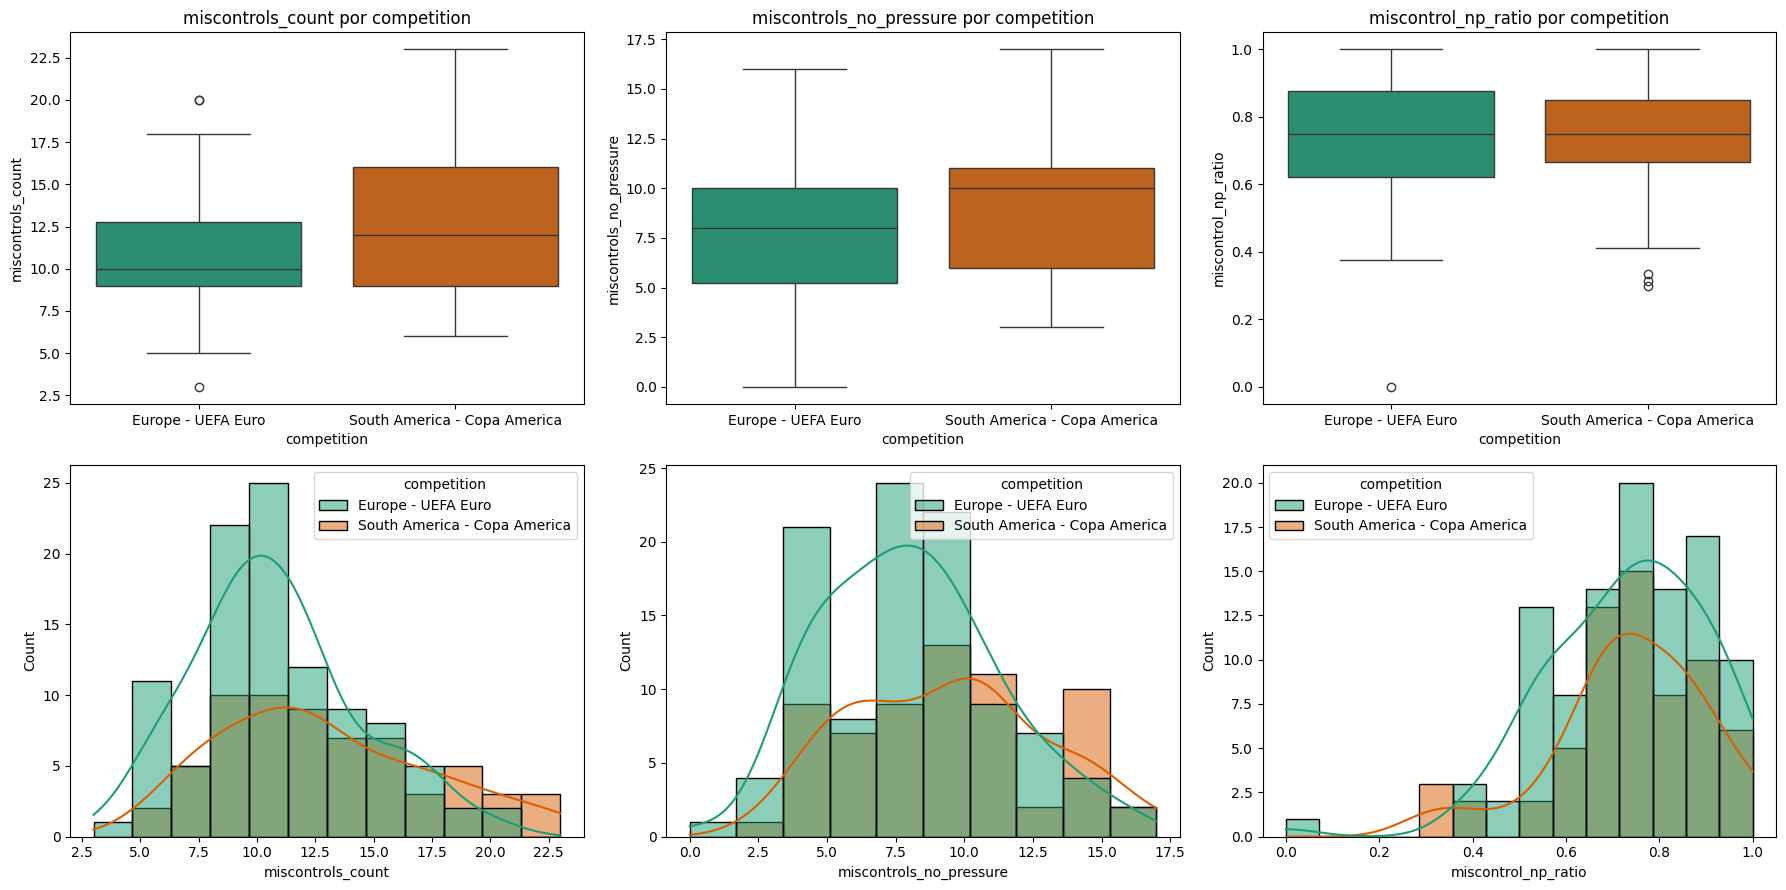

In [39]:
miscontrols_charts =boxplot_comparation(df_compared_miscontrols, 'competition', 'miscontrols_count','miscontrols_no_pressure','miscontrol_np_ratio')
miscontrols_charts

# Dribbles

In [40]:
def treatment_dribbles(df_dribbles):
  columns = ['outcome.name']
  df_dribblesinfo = pd.json_normalize(df_dribbles['dribble'])[columns]
  df_dribbles = df_dribbles.join(df_dribblesinfo)
  df_dribbles.drop(columns = ['dribble','team','team_id'], inplace = True)
  columns_final = ['id','minute','second', 'type', 'team','player',
  'play_pattern','position','match_id','team_id','under_pressure','successful_dribble']
  df_dribbles.rename(columns = {'possession_team':'team', 'possession_team_id':'team_id'}, inplace = True)
  df_dribbles['successful_dribble'] =  df_dribbles['outcome.name'].replace({'Complete': 1, 'Incomplete': 0})
  df_dribbles = df_dribbles[columns_final]
  return df_dribbles

In [41]:
df_dribbles = treatment_dribbles(df_dribbles)

C:\Users\56981\AppData\Local\Temp\ipykernel_31652\1229833011.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dribbles['successful_dribble'] =  df_dribbles['outcome.name'].replace({'Complete': 1, 'Incomplete': 0})


In [42]:
df_dribbles.head(3)

,id,minute,second,type,team,player,play_pattern,position,match_id,team_id,under_pressure,successful_dribble
0,9eabde45-32eb-4ce7-96ba-0f750df4b904,2,4,Dribble,Argentina,Nicolás Alejandro Tagliafico,From Throw In,Left Back,3943077,779,True,1
1,f4c26662-8ce3-48f8-b8c1-f91f45167b8c,2,6,Dribble,Argentina,Nicolás Alejandro Tagliafico,From Throw In,Left Back,3943077,779,True,0
2,6868d9e8-1429-42fc-ac1f-2c54979fddb9,6,0,Dribble,Colombia,James David Rodríguez Rubio,From Throw In,Center Attacking Midfield,3943077,769,True,1


In [43]:
dribbles_by_match = df_dribbles.groupby(['team','match_id']).agg(dribbles_count = ('id', 'count'),
                                                     successful_dribbles = ('successful_dribble', 'sum')).reset_index()
df_compared_dribbles = dribbles_by_match.merge(
    matches_equipos, on = ['match_id','team'], how = 'left'
    ).assign(dribbles_successful_ratio=lambda x: x['successful_dribbles'] / x['dribbles_count'])

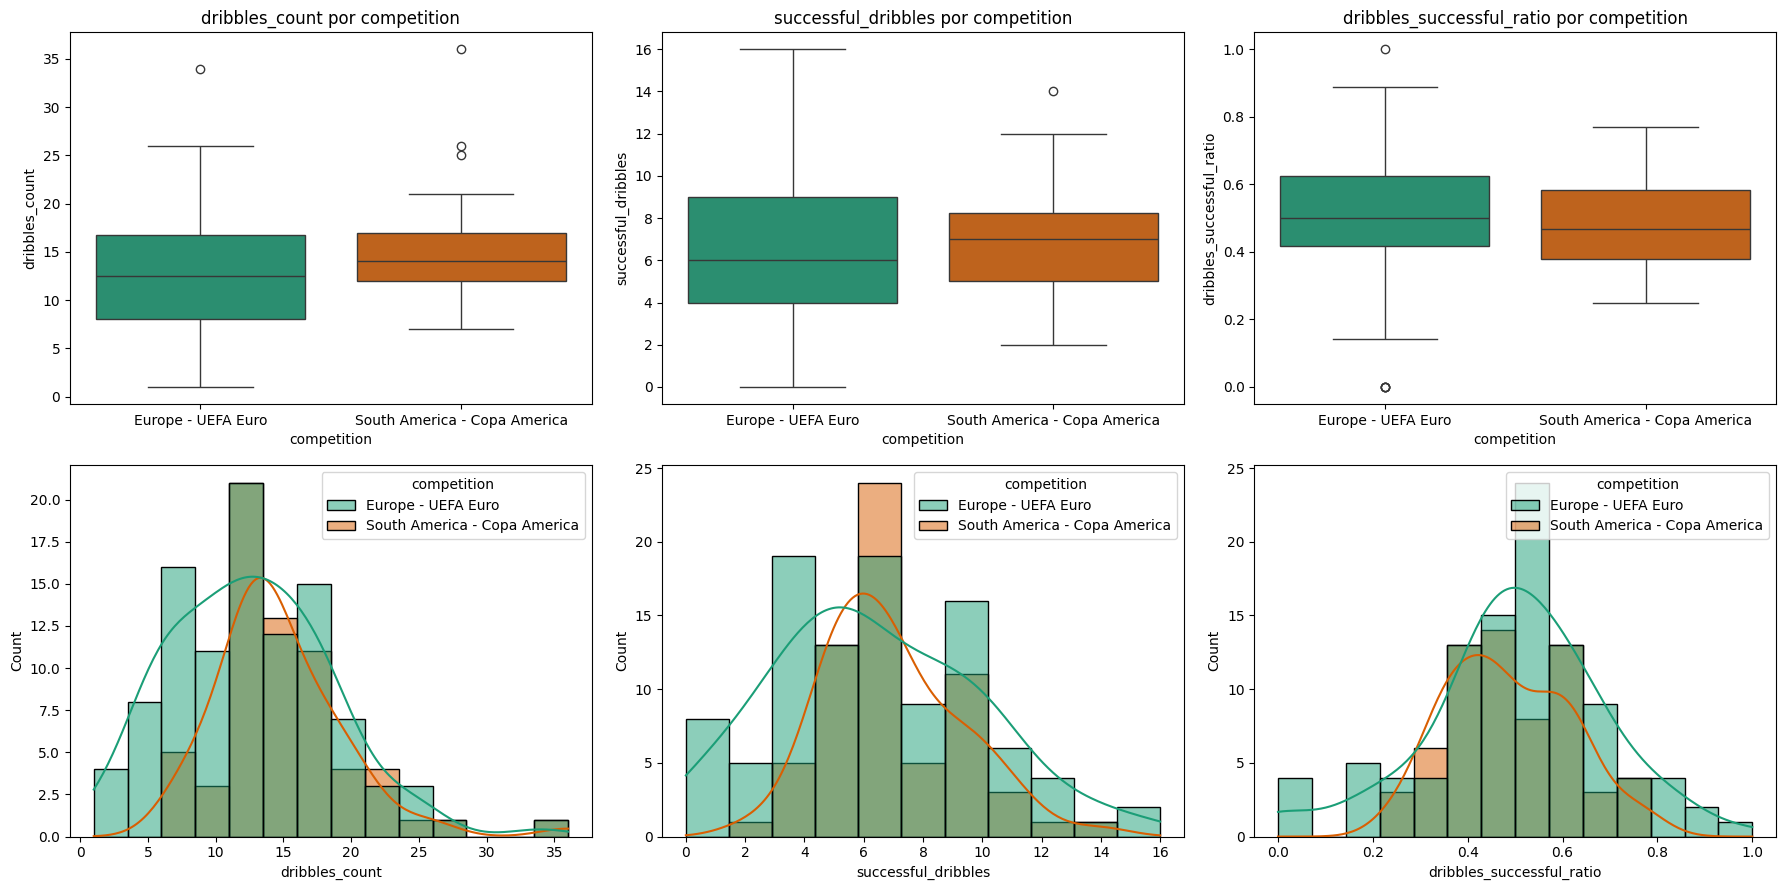

In [44]:
dribbles_charts =boxplot_comparation(df_compared_dribbles, 'competition', 'dribbles_count','successful_dribbles','dribbles_successful_ratio')
dribbles_charts

# Ball Recoverys

In [45]:
def treatment_ball_recoverys(df_ball_recoverys):
  columns = ['recovery_failure']
  df_ball_recoverysinfo = pd.json_normalize(df_ball_recoverys['ball_recovery'])[columns].fillna(0).astype(int)
  df_ball_recoverys = df_ball_recoverys.join(df_ball_recoverysinfo)
  df_ball_recoverys.drop(columns = ['ball_recovery'], inplace = True)
  # df_ball_recoverys = df_ball_recoverys.loc[df_ball_recoverys['recovery_failure'].isnull()]
  columns_final = ['id','minute','second', 'type', 'team','player',
  'play_pattern','position','match_id','team_id','recovery_failure']
  df_ball_recoverys['recovery_successful'] = df_ball_recoverys['recovery_failure'].replace({1:0, 0:1})
  return df_ball_recoverys

In [46]:
df_ball_recoverys = treatment_ball_recoverys(df_ball_recoverys)

In [47]:
df_ball_recoverys.head(3)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,match_id,possession_team_id,team_id,player_id,related_events,under_pressure,off_camera,out,recovery_failure,recovery_successful
0,91cf55f9-635f-4f9d-abe6-d63d73fadd1e,86,1,00:02:56.325,2,56,Ball Recovery,8,Colombia,Regular Play,Colombia,James David Rodríguez Rubio,Center Attacking Midfield,"[15.0, 21.3]",0.0,3943077,769,769,5695,NaN,NaN,NaN,NaN,0,1
1,9e3756c6-debb-4082-a00c-a40f66a75c9b,254,1,00:06:49.046,6,49,Ball Recovery,16,Colombia,Regular Play,Colombia,Richard Rios Montoya,Right Center Midfield,"[100.8, 67.9]",0.0,3943077,769,769,49395,[1be3bea9-4b2f-42c1-9eaf-0c45439ef391],NaN,NaN,NaN,0,1
2,e5b4705f-4b7a-4f68-b102-709c27d823bd,372,1,00:09:26.501,9,26,Ball Recovery,19,Colombia,Regular Play,Colombia,Camilo Andrés Vargas Gil,Goalkeeper,"[7.7, 44.0]",0.0,3943077,769,769,27225,[01e845f6-332c-4f65-8a44-db7799add65c],NaN,NaN,NaN,0,1


In [48]:

ball_recoverys_by_match = df_ball_recoverys.groupby(['team','match_id']).agg(recoverys_count = ('id', 'count'),
                                                     successful_recovery = ('recovery_successful', 'sum')).reset_index()

df_compared_ball_recoverys = ball_recoverys_by_match.merge(
    matches_equipos, on = ['match_id','team'],how = 'left'
    ).assign(successful_recovery_ratio=lambda x: x['successful_recovery'] / x['recoverys_count'])

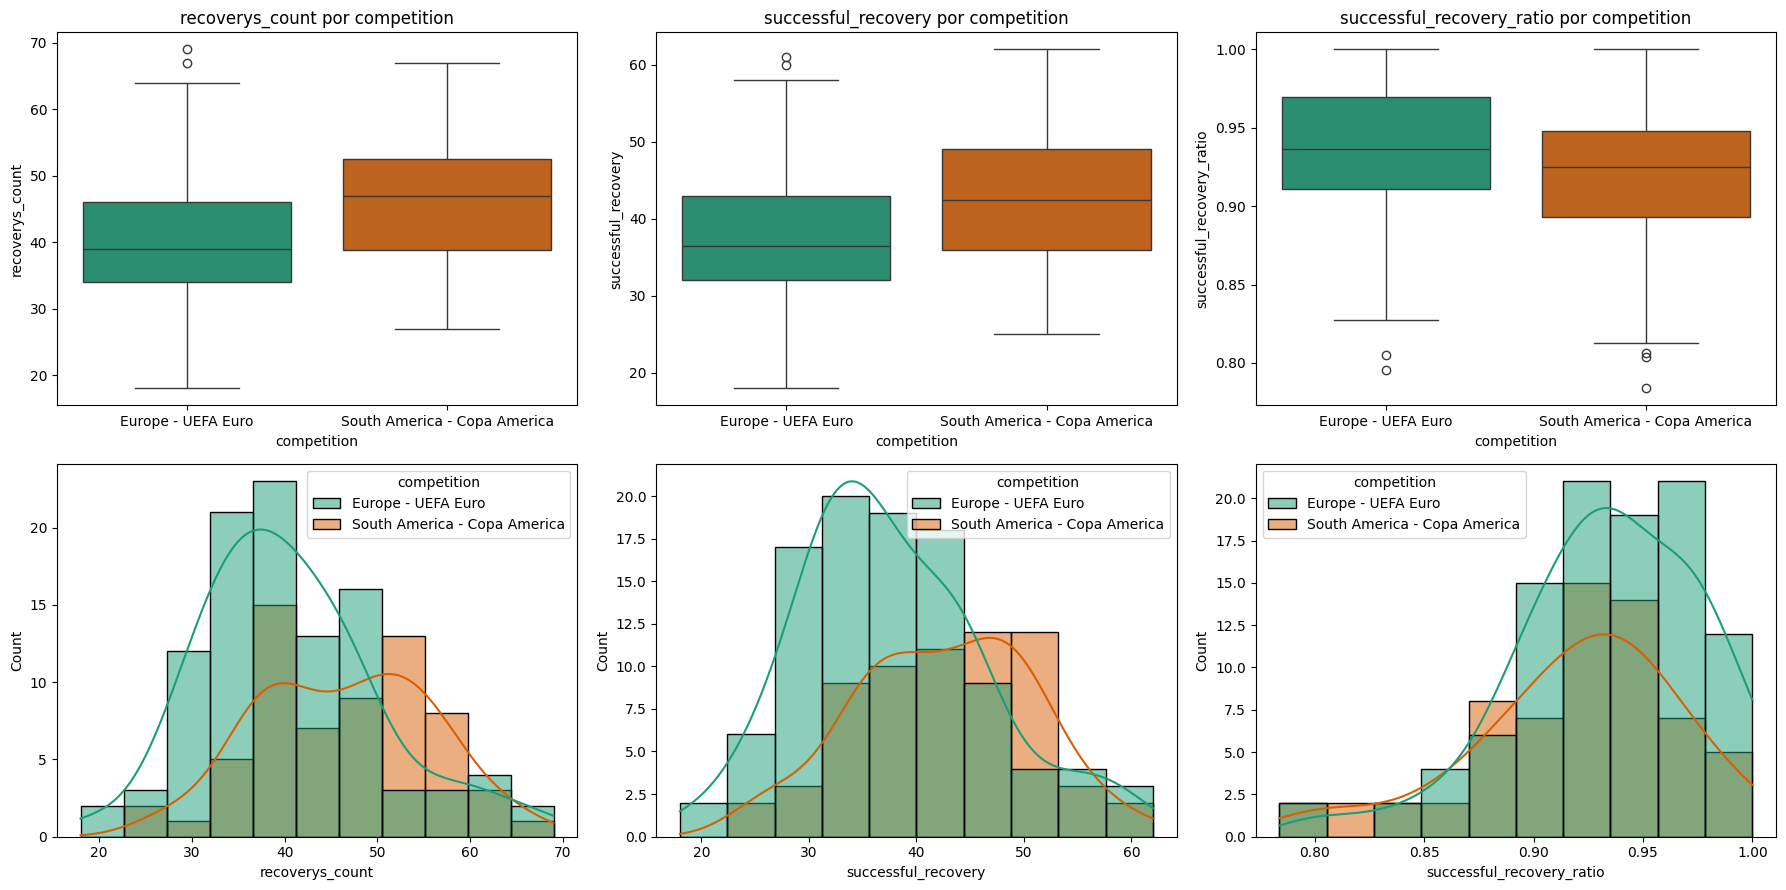

In [49]:
ball_recoverys =boxplot_comparation(df_compared_ball_recoverys, 'competition', 'recoverys_count','successful_recovery','successful_recovery_ratio')
ball_recoverys

# Interceptions

In [50]:
def treatment_interceptions(df_interceptions):
  columns = ['outcome.name']
  df_interceptionsinfo = pd.json_normalize(df_interceptions['interception'])[columns]
  df_interceptions = df_interceptions.join(df_interceptionsinfo)
  df_interceptions.drop(columns = ['interception'], inplace = True)
  columns_final = ['id','minute','second', 'type', 'team','player',
  'play_pattern','position','match_id','team_id','outcome.name']
  success = ['Won','Success Out','Success In Play','Success']
  df_interceptions = df_interceptions[columns_final]
  df_interceptions.loc[(df_interceptions['outcome.name'].isin(success)),'interception_succesful'] = 1
  df_interceptions.loc[~(df_interceptions['outcome.name'].isin(success)),'interception_succesful'] = 0
  df_interceptions['interception_succesful'] = df_interceptions['interception_succesful'].astype(int)
  return df_interceptions

In [51]:
df_interceptions = treatment_interceptions(df_interceptions)
df_interceptions.head(3)

,id,minute,second,type,team,player,play_pattern,position,match_id,team_id,outcome.name,interception_succesful
0,e82bf9e7-b184-4dfc-9147-05179f073cb4,4,2,Interception,Argentina,Enzo Fernandez,Regular Play,Left Defensive Midfield,3943077,779,Won,1
1,bf413487-03e3-4ad9-9f74-6465ba407d88,12,58,Interception,Colombia,Richard Rios Montoya,Regular Play,Right Center Midfield,3943077,769,Won,1
2,6df62101-92e4-457b-b289-6307b7a2e140,30,26,Interception,Argentina,Cristian Gabriel Romero,From Throw In,Right Center Back,3943077,779,Lost In Play,0


In [52]:
interceptions_by_match = df_interceptions.groupby(['team','match_id']).agg(
    interceptions_count = ('id', 'count'),
    successful_interceptions = ('interception_succesful', 'sum')).reset_index()

df_compared_interceptions = interceptions_by_match.merge(
    matches_equipos, on = ['match_id','team'], how = 'left'
    ).assign(successful_interception_ratio=lambda x: x['successful_interceptions'] / x['interceptions_count'])

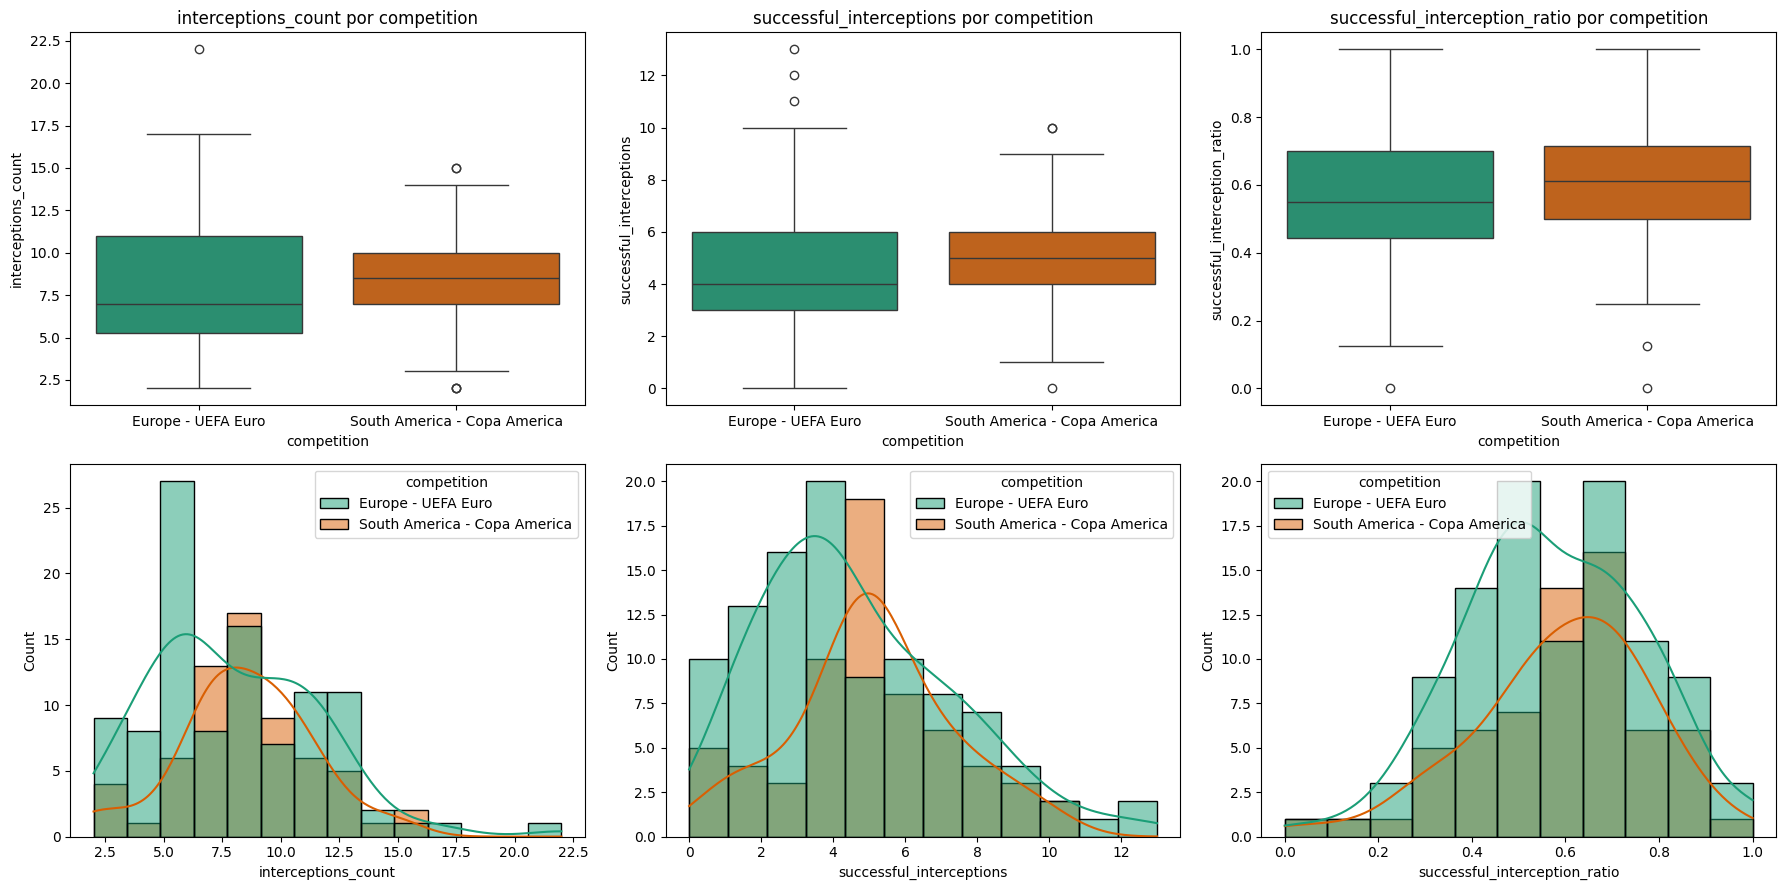

In [53]:
interceptions =boxplot_comparation(df_compared_interceptions, 'competition', 'interceptions_count','successful_interceptions','successful_interception_ratio')
interceptions

# Shots

In [54]:
def treatment_shots(df_shots):
  columns = ['statsbomb_xg',	'end_location','first_time','body_part.name','type.name','outcome.name',
             'technique.name','deflected']
  df_shotsinfo = pd.json_normalize(df_shots['shot'])[columns]
  df_shots = df_shots.join(df_shotsinfo)
  df_shots.drop(columns = ['shot'], inplace = True)
  columns_final = ['id','minute','second', 'type', 'team','player',
  'play_pattern','position','match_id','team_id','outcome.name']
  success = ['Goal','Post','Saved','Saved To Post']
  df_shots = df_shots[columns_final]
  df_shots.loc[(df_shots['outcome.name'].isin(success)),'shot_succesful'] = 1
  df_shots.loc[~(df_shots['outcome.name'].isin(success)),'shot_succesful'] = 0
  df_shots['shot_succesful'] = df_shots['shot_succesful'].astype(int)
  df_shots.loc[(df_shots['outcome.name']=='Goal'),'goal'] = 1
  df_shots.loc[~(df_shots['outcome.name']=='Goal'),'goal'] = 0
  return df_shots

In [55]:
df_shots = treatment_shots(df_shots)

In [56]:
df_shots.head(3)

,id,minute,second,type,team,player,play_pattern,position,match_id,team_id,outcome.name,shot_succesful,goal
0,3c3fd192-a115-47bc-9224-b5011bb17885,0,36,Shot,Argentina,Julián Álvarez,From Kick Off,Left Center Forward,3943077,779,Off T,0,0.0
1,b164d43a-c2cd-423e-b81d-0f461bc8c4e4,4,56,Shot,Colombia,Luis Fernando Díaz Marulanda,From Keeper,Left Center Forward,3943077,769,Saved,1,0.0
2,417a2357-d337-43c5-89c4-1ce3cf009e6f,6,12,Shot,Colombia,Jhon Andrés Córdoba Copete,From Throw In,Right Center Forward,3943077,769,Post,1,0.0


In [57]:
shots_by_match = df_shots.groupby(['team','match_id']).agg(shots_count = ('id', 'count'),
                                                     successful_shots = ('shot_succesful', 'sum'),
                                                     goals = ('goal','sum')).reset_index()

df_compared_shots = shots_by_match.merge(
    matches_equipos, on = ['match_id','team'], how = 'left'
    ).assign(successful_shots_ratio=lambda x: x['successful_shots'] / x['shots_count'],
             successful_shots_goal_ratio=lambda x: x['goals']/x['successful_shots'],
            shots_goal_ratio= lambda x: x['goals']/x['shots_count'] )
df_compared_shots['successful_shots_goal_ratio'].fillna(0.0, inplace = True)

C:\Users\56981\AppData\Local\Temp\ipykernel_31652\2295229673.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_compared_shots['successful_shots_goal_ratio'].fillna(0.0, inplace = True)


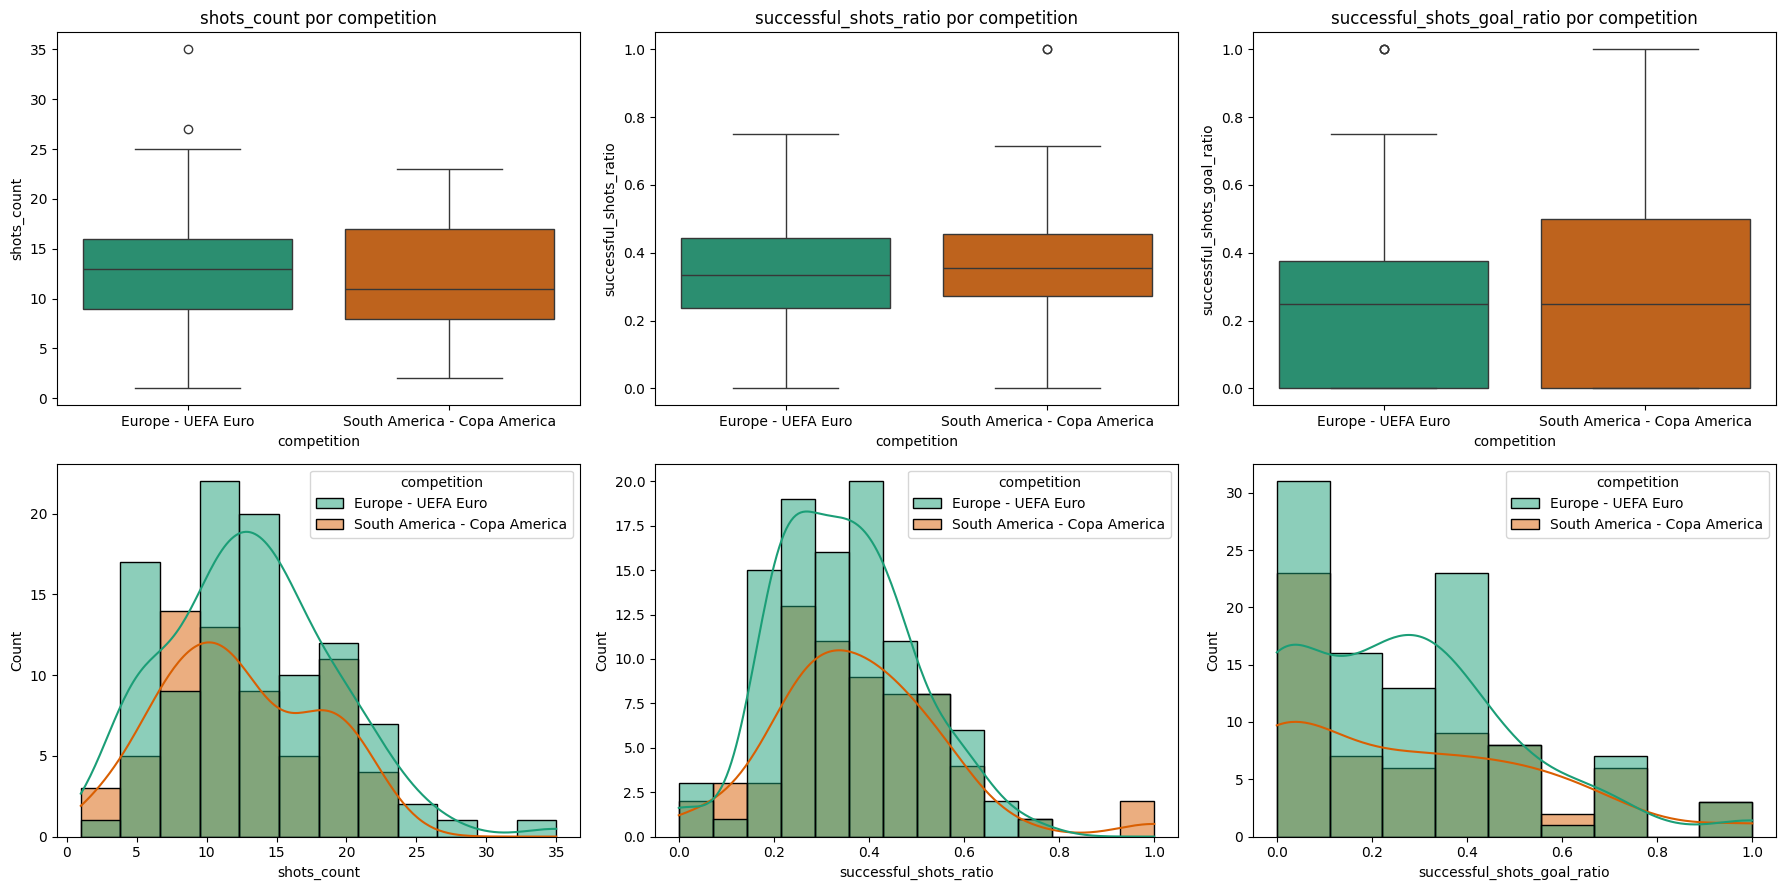

In [58]:
shots =boxplot_comparation(df_compared_shots, 'competition', 'shots_count','successful_shots_ratio','successful_shots_goal_ratio')
shots

# Comparativa Consolidada

In [59]:
#Creamos diccionario que usaremos en una función para consolidar las métrcias a comparar
dict_comparativa = {
    'df_compared_passes': ['successful_pass_ratio'],
    'df_compared_miscontrols': ['miscontrol_np_ratio'],
    'df_compared_dribbles': ['dribbles_successful_ratio'],
    'df_compared_ball_recoverys': ['successful_recovery_ratio'],
    'df_compared_interceptions': ['successful_interception_ratio'],
    'df_compared_shots': ['successful_shots_ratio','successful_shots_goal_ratio','shots_goal_ratio']  # Múltiples métricas para el mismo DataFrame
}

df_mapping = {
    'df_compared_passes': df_compared_passes,
    'df_compared_miscontrols': df_compared_miscontrols,
    'df_compared_dribbles': df_compared_dribbles,
    'df_compared_ball_recoverys': df_compared_ball_recoverys,
    'df_compared_interceptions': df_compared_interceptions,
    'df_compared_shots': df_compared_shots
}

In [60]:
def compared_ratios(dict_comparativa, df_mapping, measure):
    # Inicializamos un DataFrame vacío
    df = pd.DataFrame([])
    
    for key in dict_comparativa:
        for metric in dict_comparativa[key]:
            print(f"Obteniendo {key}: {metric}")
            df_actual = df_mapping[key]  # Obtiene el DataFrame real desde el mapeo
            
            # Realiza las agrupaciones y agregaciones por las métrcias señaladas en el diccionario
            df_grouped = df_actual.groupby('competition').agg(
                group=(metric, measure)
            ).reset_index()
        
            df_grouped.rename(columns={'group': f"{measure}_{metric}"}, inplace=True)
            
            # Transforma el DataFrame
            df_pivoted = df_grouped.melt(id_vars='competition', var_name='statistic', value_name='value').pivot(
                index='statistic', columns='competition', values='value'
            )
            
            # Concatena los resultados al DataFrame final
            df = pd.concat([df, df_pivoted], axis=0)
    #"Limpiamos índice"
    df.reset_index(inplace=True)
    df.columns.name = None
    
    return df

In [61]:
#Comparamos nuestras métricas para la mediana de cada una
compared_median = compared_ratios(dict_comparativa,df_mapping,'median')

Obteniendo df_compared_passes: successful_pass_ratio
Obteniendo df_compared_miscontrols: miscontrol_np_ratio
Obteniendo df_compared_dribbles: dribbles_successful_ratio
Obteniendo df_compared_ball_recoverys: successful_recovery_ratio
Obteniendo df_compared_interceptions: successful_interception_ratio
Obteniendo df_compared_shots: successful_shots_ratio
Obteniendo df_compared_shots: successful_shots_goal_ratio
Obteniendo df_compared_shots: shots_goal_ratio


In [62]:
#Comparamos nuestras métricas para el promedio de cada una
compared_mean = compared_ratios(dict_comparativa,df_mapping,'mean')

Obteniendo df_compared_passes: successful_pass_ratio
Obteniendo df_compared_miscontrols: miscontrol_np_ratio
Obteniendo df_compared_dribbles: dribbles_successful_ratio
Obteniendo df_compared_ball_recoverys: successful_recovery_ratio
Obteniendo df_compared_interceptions: successful_interception_ratio
Obteniendo df_compared_shots: successful_shots_ratio
Obteniendo df_compared_shots: successful_shots_goal_ratio
Obteniendo df_compared_shots: shots_goal_ratio


In [63]:
def highlight_greater(s, df):
    """Función para resaltar las celdas de las tabla donde el valor de una columna
    sea mayor al valor de la segunda columna de la misma fila"""
    if s.name == 'Europe - UEFA Euro':
        return ['background-color: green' if v else '' for v in s > df['South America - Copa America']]
    elif s.name == 'South America - Copa America':
        return ['background-color: green' if v else '' for v in s > df['Europe - UEFA Euro']]
    else:
        return ['' for _ in s]



In [64]:
# Aplicamos el estilo a la tabla
styled_df_median = compared_median.style.apply(highlight_greater, df=compared_median,  axis=0, subset=['Europe - UEFA Euro', 'South America - Copa America'])

# Mostrar el DataFrame estilizado
styled_df_median

,statistic,Europe - UEFA Euro,South America - Copa America
0,median_successful_pass_ratio,0.841433,0.800969
1,median_miscontrol_np_ratio,0.750000,0.750000
2,median_dribbles_successful_ratio,0.500000,0.468627
3,median_successful_recovery_ratio,0.936492,0.925187
4,median_successful_interception_ratio,0.550505,0.612500
5,median_successful_shots_ratio,0.333333,0.355042
6,median_successful_shots_goal_ratio,0.250000,0.250000
7,median_shots_goal_ratio,0.083333,0.090909


In [65]:
# Aplicamos el estilo a la tabla
styled_df_mean = compared_mean.style.apply(highlight_greater, df=compared_mean,  axis=0, subset=['Europe - UEFA Euro', 'South America - Copa America'])

# Mostrar el DataFrame estilizado
styled_df_mean

,statistic,Europe - UEFA Euro,South America - Copa America
0,mean_successful_pass_ratio,0.828741,0.781245
1,mean_miscontrol_np_ratio,0.733258,0.739330
2,mean_dribbles_successful_ratio,0.498371,0.485688
3,mean_successful_recovery_ratio,0.933791,0.918840
4,mean_successful_interception_ratio,0.570996,0.590331
5,mean_successful_shots_ratio,0.345554,0.380447
6,mean_successful_shots_goal_ratio,0.262346,0.283532
7,mean_shots_goal_ratio,0.095078,0.123737


# Test Estadístico

In [66]:
df_compared_passes['competition'].unique()

array(['Europe - UEFA Euro', 'South America - Copa America'], dtype=object)

In [67]:
eurocopa = df_compared_passes.loc[df_compared_passes['competition']=='Europe - UEFA Euro']['successful_pass_ratio']

In [68]:
camerica = df_compared_passes.loc[df_compared_passes['competition']=='South America - Copa America']['successful_pass_ratio']

## Test Shapiro Wilk

In [69]:
#Función para aplicar el test de Shapiro Wilk de normalidad a cada atributo que queremos medir
#para cada una de las dos competiciones
def test_normal(dict_comparativa):
    results = []

    # Iterar sobre cada dataframe y métrica en el diccionario
    for df_name, metrics in dict_comparativa.items():
        df = df_mapping[df_name]
        for dv in metrics:
            # Realizar el test de normalidad
            test_result = pg.normality(data=df, dv=dv, group='competition')
            
            # Añadir una columna indicando el atributo dv
            test_result['dv'] = dv
            test_result.reset_index(inplace=True)
            
            # Añadir los resultados a la lista
            results.append(test_result)

    # Combinar todos los resultados en un único dataframe
    df_test_normal = pd.concat(results, ignore_index=True)
    return df_test_normal


In [70]:
test_normal = test_normal(dict_comparativa)
test_normal

,competition,W,pval,normal,dv
0,Europe - UEFA Euro,0.918240,9.448690e-06,False,successful_pass_ratio
1,South America - Copa America,0.964584,6.310493e-02,True,successful_pass_ratio
2,Europe - UEFA Euro,0.949941,7.161499e-04,False,miscontrol_np_ratio
3,South America - Copa America,0.945495,6.909077e-03,False,miscontrol_np_ratio
4,Europe - UEFA Euro,0.972637,3.239897e-02,False,dribbles_successful_ratio
5,South America - Copa America,0.970891,1.346030e-01,True,dribbles_successful_ratio
6,Europe - UEFA Euro,0.956584,2.040100e-03,False,successful_recovery_ratio
7,South America - Copa America,0.955339,2.112558e-02,False,successful_recovery_ratio
8,Europe - UEFA Euro,0.986553,3.939592e-01,True,successful_interception_ratio
9,South America - Copa America,0.970706,1.316463e-01,True,successful_interception_ratio


In [71]:
test_normal.groupby('normal')['dv'].count().reset_index()

,normal,dv
0,False,11
1,True,5


## Test Levene (Homocedasticidad)

In [72]:
def test_hscd(dict_comparativa):
    results = []
    """Función que permite hacer test de heterocedasticidad para
    validar que las varianzas sean similares entre los grupos a comparar
    """
    # Iterar sobre cada dataframe y métrica en el diccionario
    for df_name, metrics in dict_comparativa.items():
        df = df_mapping[df_name]
        for dv in metrics:
            # Realizar el test de normalidad
            test_result = pg.homoscedasticity(data=df, dv=dv, group='competition')
            
            # Añadir una columna indicando el atributo dv
            test_result['dv'] = dv
            test_result.reset_index(inplace=True)
            
            # Añadir los resultados a la lista
            results.append(test_result)

    # Combinar todos los resultados en un único dataframe
    df_test_hscd = pd.concat(results, ignore_index=True)
    return df_test_hscd


In [73]:
test_hscd =  test_hscd(dict_comparativa)
test_hscd


,index,W,pval,equal_var,dv
0,levene,0.670735,0.413984,True,successful_pass_ratio
1,levene,0.579638,0.447548,True,miscontrol_np_ratio
2,levene,4.048620,0.045844,False,dribbles_successful_ratio
3,levene,0.378124,0.539461,True,successful_recovery_ratio
4,levene,0.294688,0.587969,True,successful_interception_ratio
5,levene,1.490537,0.223885,True,successful_shots_ratio
6,levene,3.316716,0.070401,True,successful_shots_goal_ratio
7,levene,5.234388,0.023422,False,shots_goal_ratio


In [74]:
test_hscd.groupby('equal_var')['dv'].count().reset_index()

,equal_var,dv
0,False,2
1,True,6


In [75]:
def obtain_ttest(dict_comparativa,type,group,x,y):
# Lista para almacenar los resultados
    results = []

    # Iterar sobre cada dataframe y métrica en el diccionario
    for df_name, metrics in dict_comparativa.items():
        df = df_mapping[df_name]
        for dv in metrics:
            # Realizar el test de homocedasticidad (Levene)
            homo_test_result = pg.homoscedasticity(data=df, dv=dv, group=group, method='levene')
            
            # Revisar si la hipótesis nula de homocedasticidad es rechazada
            if homo_test_result['pval'].iloc[0] < 0.05:
                # Usar el test de Welch para comparar medias
                welch_test_result = pg.ttest(x=df[df[group] == x][dv], y=df[df[group] == y][dv], alternative=type, correction=True)
                
                # Añadir una columna indicando el atributo dv y el nombre del dataframe
                welch_test_result['dv'] = dv
                welch_test_result['df_name'] = df_name
                
                # Añadir los resultados a la lista
                results.append(welch_test_result)
            else:
                # Si no se rechaza la hipótesis nula de homocedasticidad, realizar el test t estándar
                ttest_result = pg.ttest(x=df[df[group] == x][dv], y=df[df[group] == y][dv], alternative=type, correction=False)
                
                # Añadir una columna indicando el atributo dv y el nombre del dataframe
                ttest_result['dv'] = dv
                ttest_result['df_name'] = df_name
                
                # Añadir los resultados a la lista
                results.append(ttest_result)

    # Combinar todos los resultados en un único dataframe
    ttest_df = pd.concat(results, ignore_index=True)
    # Mostrar el dataframe resultante
    return ttest_df


In [76]:

import pandas as pd

def color_pval_cells(ttest_df):
    def highlight_cells(val):
        # Función para resaltar las celdas
        color = 'background-color: green' if val < 0.05 else ''
        return color
    
    def highlight_df_name(val, pvals):
        # Función para resaltar los nombres de los dataframes
        return 'background-color: green' if any(pvals) else ''
    
    # Aplica la función a la columna 'p-val'
    styled_df = ttest_df.style.map(highlight_cells, subset=['p-val'])
    
    # Aplica la función a la columna 'df_name' considerando los p-val
    for df_name in ttest_df['df_name'].unique():
        mask = ttest_df['df_name'] == df_name
        pvals = ttest_df[mask]['p-val'] < 0.05
        styled_df = styled_df.map(lambda x: highlight_df_name(x, pvals), subset=pd.IndexSlice[mask.index, 'df_name'])
    
    return styled_df




In [77]:
def highlight_p_value(s):
    '''Destaca el pvalue significativo (menor a 0,05)'''
    is_greater = s < 0.05
    return ['background-color: green' if i else '' for i in is_greater]

In [78]:
t_test_df = obtain_ttest(dict_comparativa,'greater','competition','Europe - UEFA Euro','South America - Copa America' )

In [79]:
t_test_df.style.apply(highlight_p_value,subset=['p-val'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,dv,df_name
0,4.678588,164.000000,greater,0.000003,[0.03 inf],0.746069,5378.935,0.998712,successful_pass_ratio,df_compared_passes
1,-0.224479,164.000000,greater,0.588668,[-0.05 inf],0.035796,0.352,0.030853,miscontrol_np_ratio,df_compared_miscontrols
2,0.510636,163.040341,greater,0.305148,[-0.03 inf],0.074720,0.388,0.119355,dribbles_successful_ratio,df_compared_dribbles
3,2.079166,164.000000,greater,0.019579,[ 0. inf],0.331553,2.487,0.664845,successful_recovery_ratio,df_compared_ball_recoverys
4,-0.634214,164.000000,greater,0.736588,[-0.07 inf],0.101135,0.414,0.011409,successful_interception_ratio,df_compared_interceptions
5,-1.359182,164.000000,greater,0.912022,[-0.08 inf],0.216741,0.804,0.001357,successful_shots_ratio,df_compared_shots
6,-0.513536,164.000000,greater,0.695866,[-0.09 inf],0.081891,0.388,0.015531,successful_shots_goal_ratio,df_compared_shots
7,-1.263883,85.465365,greater,0.895146,[-0.07 inf],0.229589,0.717,0.001040,shots_goal_ratio,df_compared_shots


In [80]:
#Solo por curiosidad, invertimos nuestra hipótesis nula
#Es decir, queremos refutar la hipótesis que dice que Europa es mejor que América
t_test_df2 = obtain_ttest(dict_comparativa,'less','competition','Europe - UEFA Euro','South America - Copa America' )

In [81]:
t_test_df2.style.apply(highlight_p_value,subset=['p-val'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,dv,df_name
0,4.678588,164.000000,less,0.999997,[-inf 0.06],0.746069,0.0,0.000000,successful_pass_ratio,df_compared_passes
1,-0.224479,164.000000,less,0.411332,[-inf 0.04],0.035796,0.352,0.077615,miscontrol_np_ratio,df_compared_miscontrols
2,0.510636,163.040341,less,0.694852,[-inf 0.05],0.074720,0.388,0.017365,dribbles_successful_ratio,df_compared_dribbles
3,2.079166,164.000000,less,0.980421,[-inf 0.03],0.331553,0.402,0.000101,successful_recovery_ratio,df_compared_ball_recoverys
4,-0.634214,164.000000,less,0.263412,[-inf 0.03],0.101135,0.414,0.155470,successful_interception_ratio,df_compared_interceptions
5,-1.359182,164.000000,less,0.087978,[-inf 0.01],0.216741,0.804,0.385419,successful_shots_ratio,df_compared_shots
6,-0.513536,164.000000,less,0.304134,[-inf 0.05],0.081891,0.388,0.128516,successful_shots_goal_ratio,df_compared_shots
7,-1.263883,85.465365,less,0.104854,[-inf 0.01],0.229589,0.717,0.416426,shots_goal_ratio,df_compared_shots
